In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#Recreate the model architecture
loaded_model = models.efficientnet_b0(weights=None)

#Change the classifier layer to 4
num_classes = 4
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=num_classes,
                    bias=True))
#Load saved weights
model_path = "/content/efficientnet_b0_model.pth"
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = loaded_model.to(device)

In [6]:
#Create a custom transform for our dataset
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform

Compose(
    Grayscale(num_output_channels=3)
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
idx_to_class = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}

In [8]:
#Create a function to make a prediction
def predict(model, img_path, transform, device=device, prob=False):

  #Open the image path
  img = Image.open(img_path)

  #Transform the image
  transformed_img = transform(img).to(device)

  #Eval mode
  model.eval()
  with torch.inference_mode():
    logits = model(transformed_img.unsqueeze(dim=0))
    probs = logits.softmax(dim=1)
    pred = probs.argmax(dim=1)

  if prob:
    title = f"Predicted Class: {idx_to_class[pred.item()]} | ", f"Probability: {max([round(x.item(), 4) for x in probs.cpu().numpy()[0]])*100}%"
  else:
    title = f"Predicted Class: {idx_to_class[pred.item()]}"

  #Plot that image
  plt.figure(figsize=(12,7))
  plt.imshow(img)
  plt.title(title)
  plt.axis(False)
  plt.show()

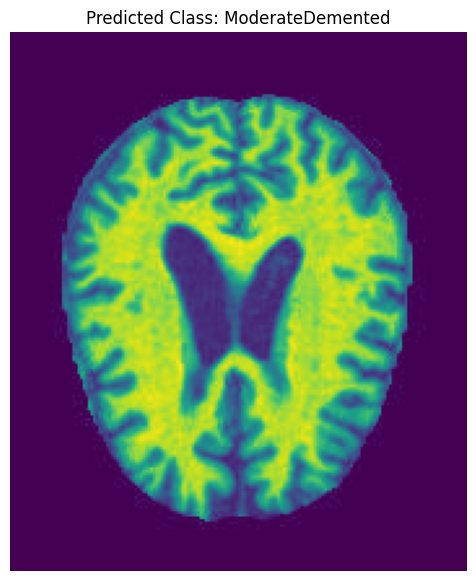

In [10]:
#Image path
img_path = "/content/moderateDem51.jpg"

#Make a prediction
predict(model=loaded_model,
        img_path=img_path,
        transform=val_transform)